In [27]:
import numpy as np
import random
import csv
import os
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from RCRI_Net import get_model,get_loss,CustomDataset,DataLoader

In [28]:
def save_points_to_csv(points, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for point in points:
            writer.writerow(point)
# Function:Type-I-Rotation            
def Type_I_Rotate(points, phi):
    num = len(points)
    center = [sum(points[:,0])/num,sum(points[:,1])/num]
    phi_rad = np.radians(phi)
    rotation_matrix = np.array([[np.cos(phi_rad), -np.sin(phi_rad)],
                                 [np.sin(phi_rad), np.cos(phi_rad)]])
    translated_points = points - np.array(center)
    rotated_points = translated_points @ rotation_matrix.T
    new_points = rotated_points + np.array(center)
    return new_points.astype(np.float32)
# Function:Type-II-Rotation
def Type_II_Rotate(points,phi):
    len_s = len(points)
    unit_s = int(len_s/360)
    K = phi*unit_s
    first_part = points[K:]  
    second_part = points[:K]  
    result = np.vstack((first_part, second_part)) 
    return result.astype(np.float32)
# Function:Rotate around any point A
def Type_I_Rotate_AnyCenter(points, phi, A):
    center = A
    phi_rad = np.radians(phi)
    rotation_matrix = np.array([[np.cos(phi_rad), -np.sin(phi_rad)],
                                 [np.sin(phi_rad), np.cos(phi_rad)]])
    translated_points = points - np.array(center)
    rotated_points = translated_points @ rotation_matrix.T
    # new_points = rotated_points + np.array(center)
    new_points = rotated_points
    return new_points.astype(np.float32)

def resample_contour(points, num_samples):
    """
    This function is used to resample the set of contour points so that they are evenly spaced.
    :param points: The input set of contour points, a numpy array with (N,2) shape
    :param num_samples: Expected number of uniformly distributed points
    :return: Contour point set after resampling, a numpy array with (shapenum_samples,2)
    """
    distances = np.sqrt(np.sum(np.diff(points, axis=0) ** 2, axis=1))
    total_length = np.sum(distances)
    sample_distance = total_length / (num_samples - 1)
    new_points = []
    cur_length = 0
    cur_index = 0
    new_points.append(points[0])
    for i in range(1, num_samples - 1):
        target_length = i * sample_distance
        while cur_length + distances[cur_index] < target_length:
            cur_length += distances[cur_index]
            cur_index += 1
        alpha = (target_length - cur_length) / distances[cur_index]
        new_point = (1 - alpha) * points[cur_index] + alpha * points[cur_index + 1]
        new_points.append(new_point)
    new_points.append(points[-1])
    return np.array(new_points)

In [34]:
# Selecting a dataset and Model
dataset = 'flavia'
DAnumber = '5s' 
batch_size = 9
line_data = np.load(f'./data/retrieval/contour/{dataset}_rec_contour_data.npy')
line_label = np.load(f'./data/retrieval/contour/{dataset}_rec_label.npy')
print(line_label)
test_data = np.load(f'./data/retrieval/contour/flavia_cls_test_data_360.npy')
test_label = np.load(f'./data/retrieval/contour/flavia_cls_test_label_360.npy')
test_dataset_new = CustomDataset(test_data, test_label)
test_loader_new = DataLoader(test_dataset_new, batch_size=batch_size, shuffle=True)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [37]:
# Test
m_PATH = f"./models/new/{dataset}_{DAnumber}_rec_Epoch_"+str(200)+".pth"
num_class = line_label[-1]+1
Model = get_model(num_class)
Model.cuda()
Model.load_state_dict(torch.load(m_PATH))
Model.eval()
mean_correct_t = []
res_correct = []
res_labels = []
res_angles = []
for index_t, (lines_t,labels_t_temp) in enumerate(test_loader_new):
    print("ID:: {} TEST::: Now Batch :{}/{}".format(0,index_t+1,len(test_dataset_new)//batch_size))
    lines_t = lines_t.cuda()
    labels_t = labels_t_temp[:,0].cuda()
    labels_deg = labels_t_temp[:,1]
    pred_t, trans_feat_t = Model(lines_t)
    pred_choice_t = pred_t.data.max(1)[1]
    correct_for_id = pred_choice_t.eq(labels_t.long().data).cpu()
    res_correct.append(correct_for_id.int().numpy())
    res_labels.append(np.asarray(labels_t.cpu()))
    res_angles.append(np.asarray(labels_deg))
print("Over")

ID:: 0 TEST::: Now Batch :1/1280
ID:: 0 TEST::: Now Batch :2/1280
ID:: 0 TEST::: Now Batch :3/1280
ID:: 0 TEST::: Now Batch :4/1280
ID:: 0 TEST::: Now Batch :5/1280
ID:: 0 TEST::: Now Batch :6/1280
ID:: 0 TEST::: Now Batch :7/1280
ID:: 0 TEST::: Now Batch :8/1280
ID:: 0 TEST::: Now Batch :9/1280
ID:: 0 TEST::: Now Batch :10/1280
ID:: 0 TEST::: Now Batch :11/1280
ID:: 0 TEST::: Now Batch :12/1280
ID:: 0 TEST::: Now Batch :13/1280
ID:: 0 TEST::: Now Batch :14/1280
ID:: 0 TEST::: Now Batch :15/1280
ID:: 0 TEST::: Now Batch :16/1280
ID:: 0 TEST::: Now Batch :17/1280
ID:: 0 TEST::: Now Batch :18/1280
ID:: 0 TEST::: Now Batch :19/1280
ID:: 0 TEST::: Now Batch :20/1280
ID:: 0 TEST::: Now Batch :21/1280
ID:: 0 TEST::: Now Batch :22/1280
ID:: 0 TEST::: Now Batch :23/1280
ID:: 0 TEST::: Now Batch :24/1280
ID:: 0 TEST::: Now Batch :25/1280
ID:: 0 TEST::: Now Batch :26/1280
ID:: 0 TEST::: Now Batch :27/1280
ID:: 0 TEST::: Now Batch :28/1280
ID:: 0 TEST::: Now Batch :29/1280
ID:: 0 TEST::: Now Batc

Prediction Accuracy: = 1.0
1.0


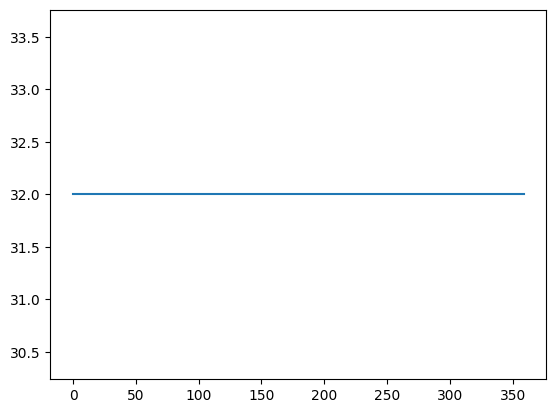

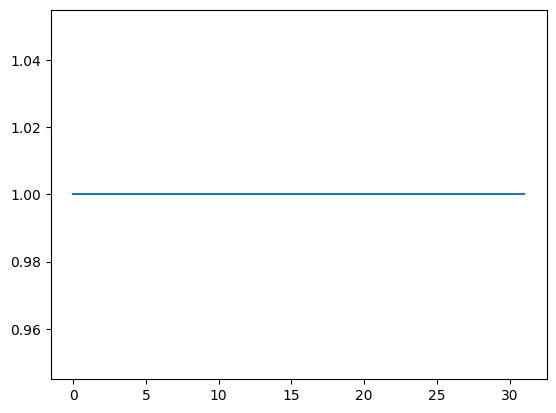

In [38]:
# Visualization of results
res_acc = np.asarray(res_correct).reshape(-1)
res_label = np.asarray(res_labels).reshape(-1)
res_angle = np.asarray(res_angles).reshape(-1)
## Plotting “Angle - Recognition Rate”
res_ang = np.zeros(360)
for i in range(len(res_angle)):
    res_ang[res_angle[i]] = res_ang[res_angle[i]] + res_acc[i]
plt.figure()
plt.plot(res_ang)
## Plotting “Classes - Recognition Rate”
count_dict = {}
for num in line_label:
    if num in count_dict:
        count_dict[num] += 1
    else:
        count_dict[num] = 1
res_cls = np.zeros(num_class)
for count,i_lab in enumerate(res_label):
    res_cls[i_lab] += res_acc[count]
for i in range(num_class):
    res_cls[i]/=count_dict[i]*360
plt.figure()
plt.plot(res_cls)
print("Prediction Accuracy: = {}".format(np.mean(res_cls)))
print(np.mean(res_ang/32))
# save
save_path1 = "./result/recognition/" + f"Angle_Acc_{dataset}_{DAnumber}_EX2" + ".csv"
save_path2 = "./result/recognition/" + f"Class_Acc_{dataset}_{DAnumber}_EX2" + ".csv"
np.savetxt(save_path1, res_ang/32.0, delimiter=',')
np.savetxt(save_path2, np.asarray(res_cls), delimiter=',')

In [26]:
res_angle.shape

(11520,)